<a href="https://colab.research.google.com/github/Guo-bot-1998/Appendicitis/blob/master/Appendicitis_colab_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [1]:
!pip install timm
!pip install tqdm
!pip install kora
!pip install fake_useragent

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.1 MB/s eta 0:00:00


In [2]:
import nibabel as nib
import numpy as np
import os
import pandas as pd
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import random
import re
import json
import tqdm
import timm
import gdown
from torch.utils.data import Dataset, DataLoader
from kora.xattr import get_id

## 存取

In [3]:
def get_data_disk(driveroot, targetdir):
  """從雲端資料夾targetdir下載檔案到colab root底下同名資料夾
  只下載沒有下載的檔案.

  driveroot為雲端檔案資料夾root"""

  if not os.path.exists('/content/' + targetdir):
    os.makedirs(targetdir)
    print(f"making {targetdir} dir...")

  files_on_drive = os.listdir(driveroot+'/'+targetdir)
  files_in_localdir = os.listdir(f"/content/{targetdir}")
  files_to_download = [f for f in files_on_drive if f not in files_in_localdir]
  files = [(filename, get_id(f'{driveroot}/{targetdir}/{filename}')) for filename in files_to_download]


  for idx, (name, file_id) in enumerate(files):

    if not file_id:
      print(f"未找到文件: {name}")
      continue

    # 下载文件
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    downloader = MediaIoBaseDownload(fh, request)

    done = False
    while not done:
      status, done = downloader.next_chunk()
      # print(f"下载 {name} 进度: {int(status.progress() * 100)}%")

    # 将文件内容写入本地文件
    local_file_path = os.path.join('/content', targetdir, name)

    with open(local_file_path, 'wb') as f:
      fh.seek(0)
      f.write(fh.read())

    print(f"{idx+1}/{len(files)}: {name} downloaded")




def process_data2(traindir, shift=0, termi=10, dropFalse=0.85, dropPos=0)\
 -> tuple[torch.tensor, torch.tensor]:
  """Reading data in "traindir" and process them.
  Taking care of memory efficiency"

  Args:
    shift: 從第幾個開始讀取
    termi: 讀取幾個
    dropFalse: 被刪除的有闌尾炎的張數比例
    dropPos: 被刪除的有闌尾炎的張數比例

  Returns:
    images: 输出的图像数据
    labels: 输出的标签数据
  """
  print(f"reading {traindir=}...")
  labels_ = read_label(labelpath)

  if labels_.index.name != 'id':
    labels_.set_index('id', inplace=True)

  #裁減過的圖片放在Cropped_[範圍]的資料夾下,用路徑名稱判斷資料使否裁減過
  cropmatch = re.search(r'Cropped', traindir)
  if not cropmatch:
    print("讀取未切片的資料夾")
    xlim, ylim, zlim = [0,512], [0,512], [0,None]
  else:
    #範圍 = xstart-xend_ystart-yend_zstart-zend
    ismatch = re.search(r'(\d+-\d+)_(\d+-\d+)_(\d+-\d+)', traindir)
    if ismatch:
      dimens = ismatch.group(0)
      labelidx = dimens.split('_')
      xlim = [int(idx) for idx in labelidx[0].split('-')]
      ylim = [int(idx) for idx in labelidx[1].split('-')]
      zlim = [int(idx) for idx in labelidx[2].split('-')]
      print(f"{xlim=}\n{ylim=}\n{zlim=}")
      if xlim[0] >= xlim[1] or ylim[0] >= ylim[1] or zlim[0] >= zlim[1]:
        print("切片格式不正确")
        return
    else:
      print("切片格式不正确")
      return


  filelist = os.listdir(traindir)
  filelist = filelist[shift:shift+termi]

  # preallocated
  if not cropmatch:
    selecteds = [labels_.loc[labels_.index.str.startswith(afile.strip('.nii.gz')+'_')] for afile in filelist]
    numcuts = [len(selected) for selected in selecteds]
    numcuts = sum(numcuts)
  else:
    numcuts = (zlim[1]-zlim[0]) * len(filelist)
  images = torch.zeros(numcuts,1, ylim[-1]-ylim[0],xlim[-1]-xlim[0])
  labels = -torch.ones(numcuts)
  nimgs = 0
  nprocess = 0

  for key in filelist:
    file_path = os.path.join(traindir, key)
    key = key.strip('.nii.gz')
    scan  = labels_.loc[labels_.index.str.startswith(key+'_')]
    value = nib.load(file_path).get_fdata()

    label_t = torch.tensor(scan['label'][zlim[0]:zlim[-1]])
    image_t = torch.from_numpy(value).float().permute(2, 0, 1).unsqueeze(1)

    #有幾筆不是512x512
    if (not cropmatch) and (image_t.shape[2] != 512 or image_t.shape[3] != 512):
      image_t = cropping(image_t)

    image_t, label_t = remove_false_images(image_t, label_t, dropFalse)
    image_t, label_t = remove_positive_images(image_t, label_t, dropPos)

    n_new = len(label_t)

    images[nimgs:nimgs+n_new] = image_t
    labels[nimgs:nimgs+n_new] = label_t
    nimgs += len(label_t)
    print(f"Process {nprocess}: {key} finished...")
    nprocess += 1


  #after drop
  counts = count_zero(images)
  images = torch.asarray(images[:len(images)-counts])
  labels = labels[labels != -1]

  return images, labels.float()




def read_test(testdir,shift=0,termi=10):
  """Reading data in "testdir"
  not memory efficient
  Args:
    shift: 從第幾個開始讀取
    termi: 讀取幾個
  Returns:
    images: 输出的图像数据
    scans_info: 每個scan的檔名和切片數(原本nii檔所包含的數量)

  """


  filelist = os.listdir(testdir)
  filelist = filelist[shift:shift+termi]
  scans_info = []

  images = []
  nprocess = 0

  for key in filelist:
    file_path = os.path.join(testdir, key)
    key = key.strip('.nii.gz')
    value = nib.load(file_path).get_fdata()
    scans_info.append((key, value.shape[2]))

    image_t = torch.from_numpy(value).float().permute(2, 0, 1).unsqueeze(1)

    images.append(image_t)
    print(f"{nprocess}: Read test {key} finished...")
    nprocess += 1

  images = torch.cat(images,dim=0)
  print(f"read {len(scans_info)} scans")

  return images, scans_info




def save_model(model, modelname="", dirname="", root=os.path.realpath("/content/drive/MyDrive/AOCR2024/params")):

  if not model:
    print("not given model")
    return

  if not os.path.exists(root):
    print(f"{root} not exists!")
    return

  print(f"model will be saved as {root}/{dirname}/{modelname}")

  if not modelname:
    modelname = input("請輸入模型儲存的檔名:")
  if not dirname:
    dirname = input("請輸入模型儲存的資料夾:")

  filename = f"{root}/{dirname}/{modelname}"

  if not os.path.exists(os.path.dirname(filename)):
    os.mkdir(os.path.dirname(filename))

  if os.path.isfile(filename+'.pth'):
      print(f"{filename}.pth exist.")
  else:
      torch.save(model.state_dict(), f'{filename}.pth')

  return filename



def read_label(excel_path) -> pd.DataFrame:
  """Reads a csv file containing ground-truth.
    The csv file should have two columns: 'id' and 'label'.
  """
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df



def write_error(logpath, e, nprocess):
  # with open(logpath, 'a') as f:
    # f.write(f"{nprocess:} error occured: {e}\n") ##! may stuck the program!!
  print(f"{nprocess:} error occured: {e}\n")


def read_submission(excel_path) -> pd.DataFrame:
  """Reads a csv file containing submission file.
    The csv file should follow the format given by Kaggle.
  """
  with open(excel_path, 'r') as f:
    df = pd.read_csv(f)
    df.set_index('id', inplace=True)
    return df




## 列印結果

In [4]:
def get_confusion(guess, truth):
  right = guess == truth
  wrong = np.logical_not(right)
  TP = np.sum(np.logical_and(right, truth == np.ones(right.shape)))
  TN = np.sum(np.logical_and(right, truth == np.zeros(right.shape)))
  FN = np.sum(np.logical_and(wrong, truth == np.ones(wrong.shape)))
  FP = np.sum(np.logical_and(wrong, truth == np.zeros(wrong.shape)))
  return (TP,FP,FN,TN)



def print_results(prediction, labels):
  if torch.is_tensor(prediction):
    prediction = prediction.cpu().numpy()
  if torch.is_tensor(labels):
    labels = labels.cpu().numpy()

  TP,FP,FN,TN = get_confusion(prediction, labels)
  print(f"\n\
      真實值\n\
  預  +-----+-----+\n\
  測| TP: {TP}| FP: {FP}|\n\
  值| FN: {FN}| TN: {TN}|\n\
      +-----+-----+ \n")

  recall = TP/(TP + FN)
  precision = TP/(TP + FP)
  recall = 0 if np.isnan(recall) else recall.item()
  precision = 0 if np.isnan(precision) else precision.item()
  F1 = 0 if recall + precision == 0 else  (2*recall*precision/(recall+precision))

  print(f"{recall=}\n{precision=}\n{F1=}\n")

## 數據裁減




In [5]:
def argumenting(images, labels, n=5):
  """
  數據增強。
  在images裡面把所有有闌尾炎的cut複製給定次數，並
  插入回images的隨機位置裡面

  Args:
    images: 输入的图像数据
    labels: 输入的标签数据
    n: 每个样本複製多少次

  Returns:
    增強后的图像数据和标签数据
  """
  where = (labels == True).nonzero(as_tuple=True)[0]
  bad_images = images[where]

  rep_imgs = bad_images.repeat(n, 1, 1, 1)
  rep_labels = torch.ones(rep_imgs.shape[0], dtype=labels.dtype)

  # import pdb
  # pdb.set_trace()
  # 隨機插入argumented圖片
  nimg = images.shape[0]
  rnd_pos = torch.randint(0, nimg, (rep_imgs.shape[0],))
  images = torch.cat((images, rep_imgs), dim=0)
  images = images[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  # 對應對置插入標籤
  labels = torch.cat((labels, rep_labels), dim=0)
  labels = labels[torch.argsort(torch.cat((torch.arange(nimg), rnd_pos)))]

  return images, labels

def remove_false_images(images, labels, ratio):
    """
    隨機在images裡面移除一定比例的無闌尾炎cut

    Args:
      images: 输入的图像数据
      labels: 输入的标签数据
      ratio: 移除的比例

    Returns:
      移除后的图像数据和标签数据
    """
    # 找出 labels == 0 的索引
    where_false = (labels == 0).nonzero(as_tuple=True)[0]
    mask = torch.ones(len(images), dtype=torch.bool)
    indices_filter = torch.randperm(len(where_false))[:int(len(where_false)*ratio)]
    mask[where_false[indices_filter]] = False
    images = images[mask]
    labels = labels[mask]

    return images, labels

def remove_positive_images(images, labels, ratio):
    # 找出 labels == 1 的索引
    where_positive = (labels == 1).nonzero(as_tuple=True)[0]
    mask = torch.ones(len(images), dtype=torch.bool)
    indices_filter = torch.randperm(len(where_positive))[:int(len(where_positive)*ratio)]
    mask[where_positive[indices_filter]] = False
    images = images[mask]
    labels = labels[mask]

    return images, labels

## 其他

In [6]:

def count_zero(images):
  count = 0
  for image in images:
    if not torch.any(image):
      count += 1
  return count

def cropping(image):
  if image.shape[2] != 512:
    start = (image.shape[2] - 512) // 2
    end = start + 512
    image = image[:, :, start:end, :]

  if image.shape[3] != 512:
    start = (image.shape[3] - 512) // 2
    end = start + 512
    image = image[:, :, :, start:end]
  return image




def custom_sort_key(val):
    parts = val.split('_')
    if len(parts) == 2 and parts[1].isdigit():
        return (parts[0], int(parts[1]))
    return (parts[0], -1)  # 使沒有_(數字)的id排最前面


def isgpu():
    """檢查是否有 CUDA 支持的 GPU"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        # raise("GPU not available")
    return device


In [7]:
device = isgpu()

GPU is available


# 掛載


In [8]:
from google.colab import drive
drive.mount('/content/drive/',)

Mounted at /content/drive/


In [9]:
!pwd

/content


In [10]:
drive_rootdir = "/content/drive/MyDrive/AOCR2024"
labelpath = '/content/drive/MyDrive/AOCR2024/TrainValid_ground_truth.csv'
# datadir ="Train_Valid_Image"
datadir ="Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped"


Use service account to access googledrive

In [11]:
import io
import googleapiclient.discovery
from google.auth.exceptions import TransportError
from google.oauth2.service_account import Credentials
from googleapiclient.http import MediaIoBaseDownload

DriveAPIcredentials = r"/content/drive/MyDrive/AOCR2024/creds/appendicitis-407217-c2f141040794.json"
credentials = Credentials.from_service_account_file(DriveAPIcredentials,scopes=["https://www.googleapis.com/auth/drive"])
drive_service = googleapiclient.discovery.build('drive', 'v3', credentials=credentials)

# 資料下載


preparing the folder on colab and setting path

913 in 39 mins

In [12]:
get_data_disk(drive_rootdir, datadir)

making Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped dir...
1/1000: Zx00FE1B9A88E88C71CF81D0736F23E88BB9C35E2BCDECF501.nii.gz downloaded
2/1000: Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF1628.nii.gz downloaded
3/1000: Zx015DF8E20804DB94E24A9B2D9DD387A47EF1C620A02026DC.nii.gz downloaded
4/1000: Zx016CBC4284052F6A74A56DAFFB0B39B95D4DEC066028AA4A.nii.gz downloaded
5/1000: Zx00FE1B9A88E88C71F8D11F50C2B5FBFEB3461E67BE1E83B8.nii.gz downloaded
6/1000: Zx014E4DF04789E7E61C3B4876CE4D122DC14E0BB842E42E7D.nii.gz downloaded
7/1000: Zx01F90B532F87127DB647612B6621F2065CA58692B921CEB4.nii.gz downloaded
8/1000: Zx01F90B532F87127D864B9194B92EDDC3B0EA988ABB5E1D1C.nii.gz downloaded
9/1000: Zx039B4A139FC862D542D2AACC247C46DFCE9EAA705B5DEF40.nii.gz downloaded
10/1000: Zx018905C639589E81D4C91553041B845F583C3365B076C8E1.nii.gz downloaded
11/1000: Zx0494BD052F6F8D5A583699BBC329C318AC7B5BE50FD9ACDA.nii.gz downloaded
12/1000: Zx052D253409F40A03B71D313382692559FB09F771A41F754A.nii.gz downloaded
13/1

In [ ]:
!curl ipecho.net/plain

34.80.136.131

Use http request pulic links of google drive files  to download (error 403. be blocked from google)

In [ ]:
# from kora.xattr import get_id
# import requests
# from fake_useragent import UserAgent
# import time

# # user_agents = [
# #     "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36",  # Chrome on Windows 10
# #     "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Safari/605.1.15",  # Safari on macOS
# #     "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:88.0) Gecko/20100101 Firefox/88.0",  # Firefox on Windows 10
# #     "Mozilla/5.0 (iPhone; CPU iPhone OS 14_4 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0 Mobile/15E148 Safari/604.1",  # Safari on iPhone
# #     "Mozilla/5.0 (Linux; Android 10; SM-G973F) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.210 Mobile Safari/537.36",  # Chrome on Android
# #     "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:88.0) Gecko/20100101 Firefox/88.0"  # Firefox on Ubuntu Linux
# # ]
# # headers = {
# #     'User-Agent': random.choice(user_agents)
# # }
# ua = UserAgent()

# files_on_drive = os.listdir(drive_rootdir+'/'+datadir)
# files_in_localdir = os.listdir(f"/content/{datadir}")
# files_to_download = [f for f in files_on_drive if f not in files_in_localdir]
# files = [(filename, get_id(f'{drive_rootdir}/{datadir}/{filename}')) for filename in files_to_download]
# # print(headers)

# t = random.randint(20,30)

# with requests.Session() as session:
#   for idx, (name, id) in enumerate(files):
#     headers = {'User-Agent': ua.random}
#     # print(headers)
#     url = f"https://drive.google.com/uc?id={id}&confirm=t"
#     # url = f"https://drive.google.com/file/d/{id}/view?usp=drive_link"
#     # url = f"https://drive.google.com//uc?id={id}&confirm=t&usp=sharing"
#     response = session.get(url, headers=headers, allow_redirects=True)
#     if response.status_code == 200:
#         with open(f"/content/{datadir}/{name}", 'wb') as file:
#             file.write(response.content)
#         print(f"{idx+1}/{len(files)}: {name}")
#     elif response.status_code == 403:
#         print(f"Error: Unable to download file. Status code: {response.status_code}")
#         # headers = {
#         #   'User-Agent': random.choice(user_agents)
#         # }
#         # print(headers)
#         s = random.randint(300,600)
#         print(f"sleeping {s} secondes...")
#         time.sleep(s)
#     else:
#         print(f"Error: Unable to download file. Status code: {response.status_code}")

#     # if (idx+1) % t  == 0:
#     #   s = random.randint(60,300)
#     #   print(f"sleeping {s} secondes...")
#     #   time.sleep(s)
#     #   t = random.randint(20,30)

# # files_on_drive = os.listdir(drive_rootdir+'/'+datadir)
# # files_in_localdir = os.listdir(f"/content/{datadir}")
# # files_to_download = [f for f in files_on_drive if f not in files_in_localdir]
# # files = [(filename, get_id(f'{drive_rootdir}/{datadir}/{filename}')) for filename in files_to_download]
# # for idx, (name, id) in enumerate(files):
# #   gdown.download(f"https://drive.google.com/uc?id={id}&confirm=t", output=f"/content/{datadir}/{name}", quiet=True, use_cookies=False)
# #   print(f"{idx+1}/{len(files)}: {name}")

In [13]:
len(os.listdir(datadir))

1000

Directly reading files from mounted google drive  
**unknown error**: stuck after reading 9 nii files

In [ ]:
# # 測試直接從mount下載
# labelpath = '/content/drive/MyDrive/AOCR2024/TrainValid_ground_truth.csv'
# datadir ="/content/drive/MyDrive/AOCR2024/Train_Valid_Image"

# process_data2(termi=5,shift=0,dropFalse=0,dropPos=0)

In [ ]:
# # 測試下載
# labelpath = '/content/drive/MyDrive/AOCR2024/TrainValid_ground_truth.csv'

# dflabel = read_label(labelpath)
# images, labels, _ =  process_data2(termi=3,shift=2,dropFalse=0,dropPos=0)

xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx0AA2C956EEA5EAEA0DC0DA2606A8F8D0F334B97FDD860E1F finished...
Process 1: Zx08DA48B45B5C7D0182C369B8E0B013CAF9EEA43199E8AFEF finished...
Process 2: Zx0800DE5C96380322E442453B99E25D6F1282F2C4A610A497 finished...
read 3 scans


In [ ]:
# s1 = labels[0:60]
# s2 = labels[60:120]
# s3 = labels[120:180]
# s2

# Dataset/Model

In [14]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, mode='train'):
        self.images = images
        self.labels = labels
        self.mode = mode

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      if self.mode == 'train' or self.mode=='valid':
        return self.images[idx], self.labels[idx]
      elif self.mode == 'test':
        return self.images[idx]

In [15]:
model_name = "tf_efficientnetv2_m"
pretrained_model = timm.create_model(model_name, pretrained=True)

# 修改輸入通道
pretrained_model.conv_stem = nn.Conv2d(1, 24, kernel_size=3, stride=2, padding=1, bias=False)

# 修改輸出類別
num_classes = 1
pretrained_model.classifier = nn.Linear(pretrained_model.classifier.in_features, num_classes)

# 添加 Sigmoid 激活函數
pretrained_model = nn.Sequential(
    pretrained_model,
    nn.Sigmoid()
)


# 檢查模型結構
# print(pretrained_model)


model.safetensors:   0%|          | 0.00/218M [00:00<?, ?B/s]

# 資料處理

In [16]:
dflabel = read_label(labelpath)
total_nii = len(os.listdir(datadir))
images, labels =  process_data2(traindir=datadir, termi=total_nii,shift=0,dropFalse=0,dropPos=0)

reading traindir='Cropped_60-316_150-406_11-71/Train_Valid_Image_cropped'...
xlim=[60, 316]
ylim=[150, 406]
zlim=[11, 71]
Process 0: Zx436CAA0C532C93523AA7FB9BC51F9A3737EAFA1D61767CC4 finished...
Process 1: Zx6CFEF464C113FCF500FF85095B28D6B6AA3D9138C1FA567C finished...
Process 2: Zx0A5FF3169135AF89B21F2A97A7278E517EC8B499B0F14C20 finished...
Process 3: Zx57410A845E6E8D25823E485244B4E8F17DDFC08B2883A6BA finished...
Process 4: ZxB5153E511119429D1DBFB3ADA85DACE4978C0D66980F3A77 finished...
Process 5: ZxE404B57455DB220618733B94A9C0E789AEB8E30AE3AEA44F finished...
Process 6: ZxD0D2911E085A983D6671361E4B4C6D3FC7C35E31ACDA7D2D finished...
Process 7: Zx656588024899FE03C3CEC05B7B5778D041E1ECD352CFE59C finished...
Process 8: Zx47F849224B4386F104A777D40C2EB9E46E8D4D948E0DF149 finished...
Process 9: ZxF2705A350ACE282D407763E07A9521B129903BCDED48B8DD finished...
Process 10: Zx47C8EC892A72C9A3A5F181DDD2EC43B051D9CB1FF54C714A finished...
Process 11: Zx04424F2CF83E0AD3059C7706FBE311FDC83AAA8265D2325D 

In [17]:
images_train, labels_train = remove_false_images(images, labels, 0.95)

In [18]:
# images_train, labels_train = remove_positive_images(images_train, labels_train, 0.5)


In [19]:
# images_train, labels_train = images, labels

In [20]:
print(images_train.shape)
print(len(labels_train))
print(images.shape)

torch.Size([7272, 1, 256, 256])
7272
torch.Size([59968, 1, 256, 256])


In [21]:
# len(labels_train)

In [22]:
# labels_train

In [23]:
#  %reset_selective images_train, labels_train

In [24]:
# %reset_selective dataset

In [25]:
# %reset_selective dataloader

In [26]:
# %reset

# 訓練 (EfficiencyNetV2_m)

第一次跑model 跑這


In [ ]:
model = pretrained_model
model = model.to(device)
start = 0

若是有接續跑模型   
跑這epoch要對上

In [30]:
model = pretrained_model
model = model.to(device)

import json
filename = input("請輸入要獲取模型路徑:")

if not os.path.isfile(filename+'.pth'):
    print(f"{filename}.pth not exist.")
else:
    print(model.load_state_dict(torch.load(filename+'.pth')))

if os.path.isfile(filename+'.json'):
  with open(f'{filename}.json', 'r') as f:
      params = json.load(f)

start = int(filename.split('_')[-1]) + 1

KeyboardInterrupt: ignored

In [28]:
# 訓練參數
num_epochs = 190
batch_size = 16
lr = 0.01
running_loss_list = []
modeldirname=input("dirname: ")

# 初始化模型、損失函數和優化器

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr)



dataset = CustomDataset(images_train, labels_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
model.train()

for epoch in range(start, num_epochs):
    running_loss = 0.0

    for j, (batch_images, batch_labels) in enumerate(dataloader):
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        outputs = model(batch_images)
        outputs = outputs.squeeze()
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if epoch % 10 == 0:
      savepath = save_model(model, f'{model_name}_{epoch}', dirname=modeldirname)

    images_train, labels_train = remove_false_images(images, labels, 0.95)
    dataset = CustomDataset(images_train, labels_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    running_loss_list.append(running_loss/len(dataloader))
    print(f"Epoch {epoch}, Loss: {running_loss/len(dataloader)}")

savepath = save_model(model, f'{model_name}_{epoch}', dirname=modeldirname)

Epoch 11, Loss: 0.1699705672062153
Epoch 12, Loss: 0.34658745760423204
Epoch 13, Loss: 0.3352509228554717
Epoch 14, Loss: 0.3215331597372247
Epoch 15, Loss: 0.3106127487499366
Epoch 16, Loss: 0.293073472396702
Epoch 17, Loss: 0.29301512655964623
Epoch 18, Loss: 0.2789027054337077
Epoch 19, Loss: 0.27081625726173425
model will be saved as /content/drive/MyDrive/AOCR2024/params/dropFalse0.95/tf_efficientnetv2_m_20
Epoch 20, Loss: 0.26617891116171033
Epoch 21, Loss: 0.24521485425807246
Epoch 22, Loss: 0.23883474895680892
Epoch 23, Loss: 0.2285963141261858
Epoch 24, Loss: 0.22027162915895057
Epoch 25, Loss: 0.20411146890938098
Epoch 26, Loss: 0.1949042706038933
Epoch 27, Loss: 0.18753993900749044
Epoch 28, Loss: 0.17969639572167667
Epoch 29, Loss: 0.16611990301527496
model will be saved as /content/drive/MyDrive/AOCR2024/params/dropFalse0.95/tf_efficientnetv2_m_30
Epoch 30, Loss: 0.16310822416299636
Epoch 31, Loss: 0.15225351875498738
Epoch 32, Loss: 0.14744333853061622
Epoch 33, Loss: 0.1

KeyboardInterrupt: ignored

## Loss圖

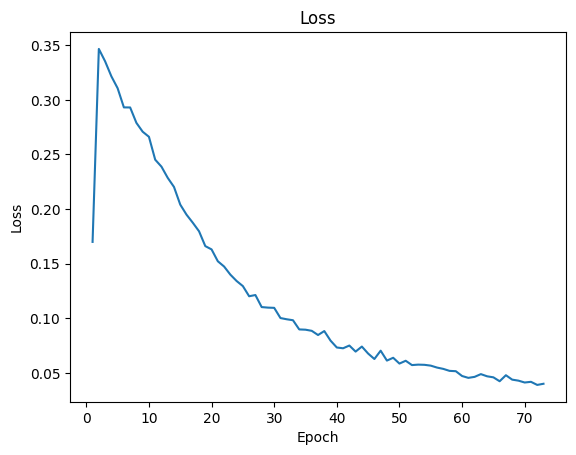

In [29]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,num_epochs+1)[:len(running_loss_list)], running_loss_list)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# figname = f'{os.path.dirname(savepath)}/{model_name}_loss.png'
# if os.path.isfile(figname):
#   print(f"{figname} exist.")
# else:
#   plt.savefig(figname)
plt.show()

lossname = f'{os.path.dirname(savepath)}/{model_name}_loss.json'

with open(f'{lossname}', 'a') as f:
  json.dump(running_loss_list, f)

# 儲存模型參數



In [ ]:
filename = save_model(model)

params = {
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'learning_rate': lr,
}

if os.path.isfile(filename+'.json'):
    print(f"{filename}.json exist.")
else:
    with open(f'{filename}.json', 'w') as f:
        json.dump(params, f)

model will be saved under /content/drive/.shortcut-targets-by-id/1sDWsPGsIDappaJPbkJswWmLhx1q6LRdv/AOCR2024/params
請輸入模型儲存的檔名:tf_efficientnetv2_m_100
請輸入模型儲存的資料夾:dropFalse0.8


# 讀取模型參數

In [19]:
model = pretrained_model
model = model.to(device)

In [20]:
import json
filename = input("請輸入要獲取模型路徑:")

if not os.path.isfile(filename+'.pth'):
    print(f"{filename}.pth not exist.")
else:
    print(model.load_state_dict(torch.load(filename+'.pth')))

if os.path.isfile(filename+'.json'):
  with open(f'{filename}.json', 'r') as f:
      params = json.load(f)

請輸入要獲取模型路徑:/content/drive/MyDrive/AOCR2024/params/dropFalse0.95/tf_efficientnetv2_m_10
<All keys matched successfully>


# 評估


In [40]:
# 評估設置
try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)

dataset = CustomDataset(images_train, labels_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

16


NameError: ignored

In [ ]:

# testing_loss_list = []
criterion = nn.BCELoss()
predict_list = torch.tensor([]).to(device)

model.eval()
with torch.no_grad():
    testing_loss = 0.0
    correct = 0
    total = 0
    for j, (batch_images, batch_labels) in enumerate(dataloader):
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
        outputs = model(batch_images).squeeze()
        predicted = (outputs > 0.5).int()
        loss = criterion(outputs, batch_labels)
        testing_loss += loss.item()
        # if predicted.dim() == 0:
        #   predicted = predicted.unsqueeze(0)
        predict_list = torch.cat((predict_list,predicted),0)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

print(f"Accuracy of the network on the {len(predict_list)} test images: {100 * correct / total}%")
print(f"Loss: {testing_loss/len(dataloader)}")
predict_listq = predict_list.cpu()



Accuracy of the network on the 8000 test images: 99.1875%
Loss: 0.0209375872412013


Accuracy of the network on the 15592   
training images: 99.20472036942022%  
Loss: 0.03187363331013983


In [ ]:
print_results(predict_listq, labels)


      真實值
  預  +-----+-----+
  測| TP: 608| FP: 61|
  值| FN: 4| TN: 7327|
      +-----+-----+ 

recall=0.9934640522875817
precision=0.9088191330343797
F1=0.9492583918813428



# Test

images讀進來是疊在一起的。 需要info紀錄images檔名順序與分割情況

In [55]:
testdir = "Cropped_60-316_150-406_11-71/Test_Image_cropped"

In [31]:
get_data_disk(drive_rootdir, testdir)


making Cropped_60-316_150-406_11-71/Test_Image_cropped...
1/200: Zx05B14FDAD8DE03B10E1C560619C12C542747E39A00BC1943.nii.gz downloaded
2/200: Zx01948F47276376729E6CD0FC35E175861DDDE016E73A6F61.nii.gz downloaded
3/200: Zx00FE1B9A88E88C71917ECC1EDD774252C072CA5FDB12C01B.nii.gz downloaded
4/200: Zx05D5C78127C46803A2A09A76E03ED07405D28012A0536000.nii.gz downloaded
5/200: Zx06170DED67884FED8E4A2B173346E1A698644BB8D971FFCB.nii.gz downloaded
6/200: Zx0B26523F097982195CAE5A8EC2674CE36E15988A529317CD.nii.gz downloaded
7/200: Zx0CFEAEA49D4E19D1DB3BAE1248C9AE42D815CA7B52CC9E76.nii.gz downloaded
8/200: Zx0D0A3D4D2C6DF934AF9D016A5B8923F6BF5746DA99CA00D6.nii.gz downloaded
9/200: Zx0D7F914BAEC987017F3C179833AAFC697C1DA5A8F6CB6F16.nii.gz downloaded
10/200: Zx0FF377252BE891AC0DC9A1CABC405DA08650AFE8A28C9D04.nii.gz downloaded
11/200: Zx1065B0DE07F9AF895D255A52750579EE21428FAB2E575FE3.nii.gz downloaded
12/200: Zx0E3C20D9BB248666F8C1605B9A9D726237A5626AD91AF5DF.nii.gz downloaded
13/200: Zx15FB4DF1D36A7B4AE

In [56]:
images_test, info = read_test(testdir,termi=200,shift=0)

0: Read test Zx2982812805D4A3FA5078DB705FF20793142A1A712F5108B5 finished...
1: Read test ZxC603C543C6AFBFCDBD7C4E19389893035928DA4FA999679C finished...
2: Read test Zx3FC388FF59A43E76DCBA3C47ABC0E803E488FA570BEDED99 finished...
3: Read test ZxA7928107608AC56E5D6A089B9DEBF2583A47AE95DD4FB78F finished...
4: Read test ZxAE84E65DFAE5468A0E0476F8B943380CE6B004D338BBAA45 finished...
5: Read test Zx7F411E894A937F74C087D521932763C8800CB193A14168A4 finished...
6: Read test ZxD6C4F406BC86A11667A76E66676A79B78A83F5DE3219D466 finished...
7: Read test Zx4F54B6C5232290798B967948DE6D2D33CB2085006FD32EE9 finished...
8: Read test ZxDAADCC811EB06CD677BC2B725B5D2084623C2BF31273631E finished...
9: Read test ZxC823CFB8F488A6A02B8B88DF93C052ED1B441EE6F73FFF60 finished...
10: Read test ZxCC42A7155619FA3703EAF742893B8B292D91D0D647A15B0A finished...
11: Read test ZxF6938B66955EC3D5CD0973DF5A2E10245E91AB67F1F7CA12 finished...
12: Read test ZxAEA8C5DDF7E396A8F82325EDE5CD22DC77292443081D45A4 finished...
13: Read 

In [57]:
images_test.shape

torch.Size([12000, 1, 256, 256])

In [71]:
%reset_selective images_test

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [58]:
try:
  batch_size = params['batch_size']
except:
  batch_size = int(input("batch_size:"))
print(batch_size)

dataset = CustomDataset(images_test, None, mode='test')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


16


In [59]:
model.eval()

predict_list = torch.tensor([]).to(device)
with torch.no_grad():  # 不更新梯度
    for j, batch_images in enumerate(dataloader):
        batch_images = batch_images.to(device)
        outputs = model(batch_images)
        predicted = (outputs.squeeze() > 0.5).int()

        # if predicted.dim() == 0:
        #   predicted = predicted.unsqueeze(0)
        predict_list = torch.cat((predict_list,predicted),0)


predict_listq = predict_list.cpu()

In [60]:
predict_listq.sum()

tensor(977.)

# 輸出至submission.csv

訓練過程不改變資料順序, 所以輸出順序同輸入.   
predict值跟隨images順序, 照著info把每個predict值(label)與檔名(id)對上. 輸出成提交格式

In [61]:
def cont(l):
  "1是否連續"
  f1 = False
  f2 = False
  for i in range(len(l)):
    if (l[i] == 1):
      f1 = True
    if (l[i] == 0):
      if (f1):
        f2 = True
    if (l[i] == 1) and f2:
      return False
  return True

def yes(predict):
  return int(sum(predict) >= 3)



predict_list = predict_listq.numpy()

## 還原id與對應label，假設key按照scan輸入順序排列,每個key對應的scan的cuts數是nslice
output = {}
k = 0  #第幾個scan
ii = 0   #每個key輪到第幾個
id, nslice = info[k][0], info[k][1]
for i in range(len(predict_list)):

  if (ii >= nslice):
    #該換下一個scan了
    output[id] = yes(predict_list[i-nslice:i]) #評估方式

    k += 1
    ii = 0
    id, nslice = info[k][0], info[k][1]

  label = predict_list[i]
  output[id+f'_{ii}'] = int(predict_list[i])
  ii += 1

output[id] = yes(predict_list[(i+1)-ii:]) #補上最後一個scan評估
# import pdb
# pdb.set_trace()
output = list(output.items())
dfout = pd.DataFrame(output)
dfout.columns = ['id', 'label']
dfout = dfout.sort_values(by='id', key=lambda x: x.map(custom_sort_key))
filename = input("輸入提交路徑(default for submission)")
if filename == '':
  filename = 'submission'
dfout.to_csv(f"{filename}"+'.csv', index=False)

輸入提交路徑(default for submission)/content/drive/MyDrive/AOCR2024/params/dropFalse0.8/cropped


In [ ]:
info

In [ ]:
dfout

# 查看submission.csv

In [ ]:
!pwd

In [ ]:
dftest = read_submission('fisrt_80.csv')
# dftest = read_submission('submission.csv')
dflabel = read_label("TrainValid_ground_truth.csv")

In [ ]:
len(dftest)

In [ ]:
import re


# 抓出scan-level data
pattern = re.compile(r'.*_[0-9]+$')  # 正則表達式匹配 "_數字" 結尾
mask = ~dftest.index.str.match(pattern)
scan_guess = np.array(dftest[mask]['label'])
scan_truth = np.array(dflabel.loc[dftest[mask]['label'].index]['label'])

mask = ~mask
cut_guess = np.array(dftest[mask]['label'])
cut_truth = np.array(dflabel.loc[dftest[mask]['label'].index]['label'])

In [ ]:
ss = 10
print("="*ss + "F1 score on scan level" + "="*ss)
print_results(scan_guess, scan_truth)
print(),print()
print("="*ss + "F1 score on cut level" +"="*ss )
print_results(cut_guess, cut_truth)

# 其他指令
不在工作流
當參考

In [ ]:
import time
datadir = 'Train_Valid_Image'
for idx, afile in enumerate(os.listdir(datadir)):
  file_path = os.path.join(datadir, afile)
  time.sleep(1)
  nii_file =  nib.load(file_path)
  print(f"{idx}: read {afile}")

In [ ]:
pattern = re.compile(r'.*_[0-9]+$')  # 正則表達式匹配 "_數字" 結尾
mask = dftest.index.to_series().str.match(pattern)
dflabel_ = dftest[mask]
dflabel_.index.map(lambda x : x.split('_')[1]).sort_values()[-3:]

In [ ]:
import random

# 假設這是您的列表
my_list = np.array([1, 2, 3, 4])

mask = [True, False, False, True]
my_list[mask]

In [ ]:
datadir ="TrainValid_Image/train_data"
labelpath = 'TrainValid_ground_truth.csv'
labels_ = read_label(labelpath)


filelist = os.listdir(datadir)
filelist = filelist[10:20]
selecteds = [labels_.loc[labels_.index.str.startswith(afile.strip('.nii')+'_')] for afile in filelist]
scans_info = []
# preallocated
print("enter")
numcuts = [len(selected) for selected in selecteds]
numcut = sum(numcuts)

In [ ]:
numcuts = [len(selected) for selected in selecteds]

In [ ]:
img = nib.load('Train_Valid_Image/Zx00AD16F8B97A53DE6E7CFE260BDF122F0E655659A3DF1628.nii.gz')


In [ ]:
drive.flush_and_unmount()

In [ ]:
t1 = torch.randint(3,(5,1,2,2))
lab = torch.tensor([1,1,1,1,1])
t1

In [ ]:
remove_positive_images(t1,lab,0.79)

In [ ]:
!pip install -U --no-cache-dir gdown gdown

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown https://drive.google.com/drive/folders/1C7HXpHMw1Alvwif9hO97FUzfn4rhxG8B -O Train_Valid_Image --folder --remaining-ok